In [1]:
import networkx as nx  
import collections  
import matplotlib.pyplot as plt  
import numpy as np
import random
import multiprocessing

In [2]:
G = nx.read_edgelist('datasets/email.edgelist.txt')
print(G)

Graph with 57194 nodes and 93090 edges


### Tamanho da Rede
O NetworkX oferece funções diretas para obter o número de nós: G.number\_of\_nodes() ou, de forma mais concisa, len(G).

N nós.

In [3]:
num_nodes = G.number_of_nodes()  
print(f"Tamanho da Rede (Número de Nós): {num_nodes} nós")


Tamanho da Rede (Número de Nós): 57194 nós


### Número de Links (Arestas)

O NetworkX fornece a função G.number\_of\_edges() para obter o número total de arestas. Alternativamente, o método G.size() oferece um resultado idêntico.9 Para a rede em análise, assume-se que contém


M links.

In [4]:
num_edges = G.number_of_edges()  
print(f"Número de Links (Arestas): {num_edges} links")

Número de Links (Arestas): 93090 links


### Grau Médio (Average Degree)

O grau médio, ⟨k⟩, é a média do número de conexões por nó na rede, oferecendo um resumo conciso do nível de conectividade geral da rede.

Para redes não direcionadas, o grau médio é calculado como 2M/N, uma vez que cada aresta contribui para o grau de dois nós, ou simplesmente como a soma de todos os graus dividida pelo número de nós.

Em redes direcionadas, o grau médio de entrada (in-degree), o grau médio de saída (out-degree) e o grau total médio são matematicamente equivalentes a M/N

In [5]:
# Cálculo do grau médio para um grafo não direcionado  
# Para grafos direcionados, o cálculo seria G.number_of_edges() / G.number_of_nodes()  
if G.is_directed():  
    avg_degree = G.number_of_edges() / G.number_of_nodes()  
    print(f"Grau Médio (Rede Direcionada): {avg_degree:.2f} passos")  
else:  
    avg_degree = (2 * G.number_of_edges()) / G.number_of_nodes()  
    print(f"Grau Médio (Rede Não Direcionada): {avg_degree:.2f} passos")

Grau Médio (Rede Não Direcionada): 3.26 passos


### Distribuição de Graus (Degree Distribution)

A distribuição de graus, P(k), quantifica a probabilidade de um nó selecionado aleatoriamente na rede ter exatamente k conexões.

Metodologia de Cálculo e Visualização:  

O processo de cálculo envolve primeiro a obtenção do grau (ou in-degree/out-degree para grafos direcionados) de cada nó na rede. Em seguida, a frequência de cada valor de grau único é contada para construir a distribuição.

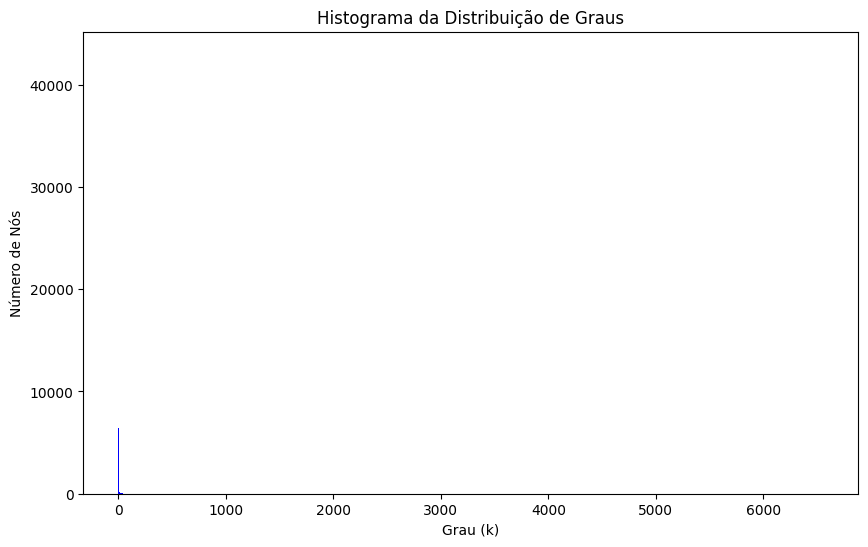

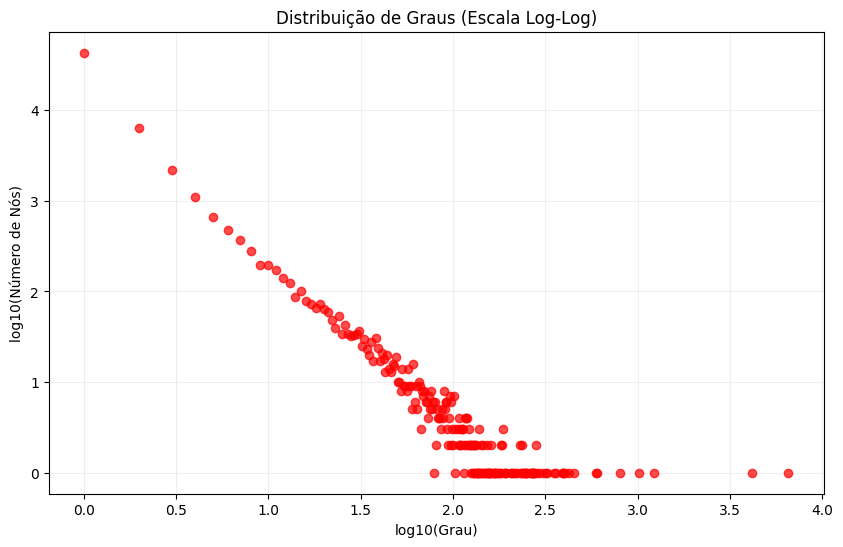

In [6]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_counts = collections.Counter(degree_sequence)  
deg, cnt = zip(*degree_counts.items())

# Filtrar contagens zero para o gráfico log-log (logaritmo de zero é indefinido)  
positive_cnt_indices = np.array(cnt) > 0  
logx = np.log10(np.array(deg)[positive_cnt_indices])  
logy = np.log10(np.array(cnt)[positive_cnt_indices])

# Histogram Plot  
plt.figure(figsize=(10, 6)) 
plt.bar(deg, cnt, width=0.8, color='b')  
plt.title("Histograma da Distribuição de Graus")  
plt.xlabel("Grau (k)")  
plt.ylabel("Número de Nós")  
plt.show()

# Log-Log Plot  
plt.figure(figsize=(10, 6))  
plt.plot(logx, logy, 'o', color='r', alpha=0.7)  
plt.title("Distribuição de Graus (Escala Log-Log)")  
plt.xlabel("log10(Grau)")  
plt.ylabel("log10(Número de Nós)")  
plt.grid(True, which="both", ls="-", alpha=0.2)  
plt.show()

### Média das Distâncias entre Pares (Average Shortest Path Length)

A média das distâncias entre pares (ASPL), denotada como ⟨L⟩, é definida como o número médio de passos (arestas) ao longo dos caminhos mais curtos para todos os pares possíveis de nós na rede. Serve como uma medida crucial da eficiência da rede no transporte de informações ou massa. Um ASPL menor geralmente indica uma rede mais eficiente, interconectada e facilmente navegável, onde a informação pode viajar rapidamente entre quaisquer dois pontos.

In [7]:
def estimated_average_path_length(graph, num_samples):
    total_distances = 0
    num_paths = 0
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(num_samples, len(nodes)))

    for source_node in sampled_nodes:
        # Calcula o caminho mais curto de 'source_node' para todos os outros nós
        lengths = nx.single_source_shortest_path_length(graph, source_node)
        for target_node, length in lengths.items():
            if source_node != target_node: # Não conte distância de nó para ele mesmo
                total_distances += length
                num_paths += 1
    return total_distances / num_paths if num_paths > 0 else 0


### F. Diâmetro da Rede (Diameter)

O diâmetro de uma rede é definido como o caminho mais curto mais longo entre quaisquer dois nós na rede. Ele representa a separação máxima ou a "distância" que a informação ou influência deve percorrer dentro da rede. É uma métrica crítica para entender a compactação geral da rede, sua eficiência e potenciais gargalos. Um diâmetro menor geralmente indica uma rede mais interconectada e eficiente.

In [8]:
def estimated_diameter(graph, num_samples):
    max_overall_distance = 0
    nodes = list(graph.nodes())
    # Garante que não se amostre mais nós do que existem
    sampled_nodes = random.sample(nodes, min(num_samples, len(nodes)))

    for source_node in sampled_nodes:
        # Calcula o caminho mais curto de 'source_node' para todos os outros nós
        # nx.single_source_shortest_path_length retorna um dicionário {destino: distancia}
        lengths = nx.single_source_shortest_path_length(graph, source_node)

        # Encontra a maior distância a partir deste nó de origem
        # Exclui a distância 0 de um nó para ele mesmo
        if lengths:
            max_current_distance = max(length for length in lengths.values() if length > 0)
            if max_current_distance > max_overall_distance:
                max_overall_distance = max_current_distance
    return max_overall_distance


In [9]:
def process_component(graph_component, results_queue):
    """
    Processa um subgrafo e adiciona os resultados à fila.
    """    
    # Lógica para processar o grafo_componente, por exemplo,
    # calcular o grau médio ou encontrar componentes conectados.
    # Substitua com sua própria lógica de processamento.
    if nx.is_connected(graph_component):
        print(f'{graph_component} \n')
        avg_path_length_exact = nx.average_shortest_path_length(graph_component)        
    else:          
        print(f'{graph_component} \n')
        avg_path_length_exact = nx.average_shortest_path_length(graph_component)        
    
    results_queue.put(avg_path_length_exact)


In [18]:

def main():
    """
    Exemplo de uso de multiprocessing com NetworkX.
    """
    
    # Divide o grafo em componentes (subgrafos)
    components = list(sorted(nx.connected_components(G), key=len, reverse=False)) 

    # Cria uma fila para resultados
    results_queue = multiprocessing.Queue()

    # Cria e inicia processos para cada componente
    processes = []
    for component in components[:189]:
        graph_component = G.subgraph(component)
        p = multiprocessing.Process(target=process_component, args=(graph_component, results_queue))
        processes.append(p)
        p.start()

    # Aguarda todos os processos terminarem
    for p in processes:
        p.join()

    # Coleta os resultados da fila
    results = []
    while not results_queue.empty():
        results.append(results_queue.get())

    # Imprime os resultados
    print("Resultados do processamento dos componentes:", sorted(results, reverse=True))

main()

Graph with 1 nodes and 1 edges 

Graph with 1 nodes and 1 edges 

Graph with 1 nodes and 1 edges 

Graph with 1 nodes and 1 edges 

Graph with 1 nodes and 1 edges 
Graph with 2 nodes and 1 edges 


Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 


Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 





Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 



Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 



Graph with 2 nodes and 1 edges 

Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 
Graph with 2 nodes and 1 edges 


Graph with 2 nodes and 1 edges 


Graph with